# SVM Analysis of the Iris Dataset

In this notebook we perform a comprehensive analysis of Support Vector Machines (SVM) using the Iris dataset.

## Contents:
1. **Dataset loading and exploration**
2. **Distribution visualization with seaborn**
3. **Training with different kernels**
4. **Hyperparameter optimization (Grid Search)**
5. **Evaluation and metrics**
6. **Hyperplane visualization**
7. **PCA 2D visualization**
8. **Kernel comparison**

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
from sklearn.datasets import load_iris
from sklearn.svm import SVC

In [40]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Dataset Loading and Exploration

In [41]:
# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Create DataFrame for analysis
df = pd.DataFrame(X, columns=feature_names)
df['Species'] = [target_names[i] for i in y]

print("Iris Dataset - General Information")
print("=" * 60)
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(target_names)}")
print(f"Classes: {target_names}")
print("\nDataset shape:", X.shape)
print("\nFirst rows:")
print(df.head(10))

Iris Dataset - General Information
Number of samples: 150
Number of features: 4
Number of classes: 3
Classes: ['setosa' 'versicolor' 'virginica']

Dataset shape: (150, 4)

First rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   
5                5.4               3.9                1.7               0.4   
6                4.6               3.4                1.4               0.3   
7                5.0               3.4                1.5               0.2   
8                4.4               2.9                1.4               0.2   
9                4.9      

In [42]:
# Descriptive statistics
print("\nDescriptive Statistics by Species:")
print("=" * 60)
print(df.groupby('Species').describe().round(2))


Descriptive Statistics by Species:
           sepal length (cm)                                        \
                       count  mean   std  min   25%  50%  75%  max   
Species                                                              
setosa                  50.0  5.01  0.35  4.3  4.80  5.0  5.2  5.8   
versicolor              50.0  5.94  0.52  4.9  5.60  5.9  6.3  7.0   
virginica               50.0  6.59  0.64  4.9  6.22  6.5  6.9  7.9   

           sepal width (cm)        ... petal length (cm)       \
                      count  mean  ...               75%  max   
Species                            ...                          
setosa                 50.0  3.43  ...              1.58  1.9   
versicolor             50.0  2.77  ...              4.60  5.1   
virginica              50.0  2.97  ...              5.88  6.9   

           petal width (cm)                                       
                      count  mean   std  min  25%  50%  75%  max  
Species           

## 2. Distribution Visualization

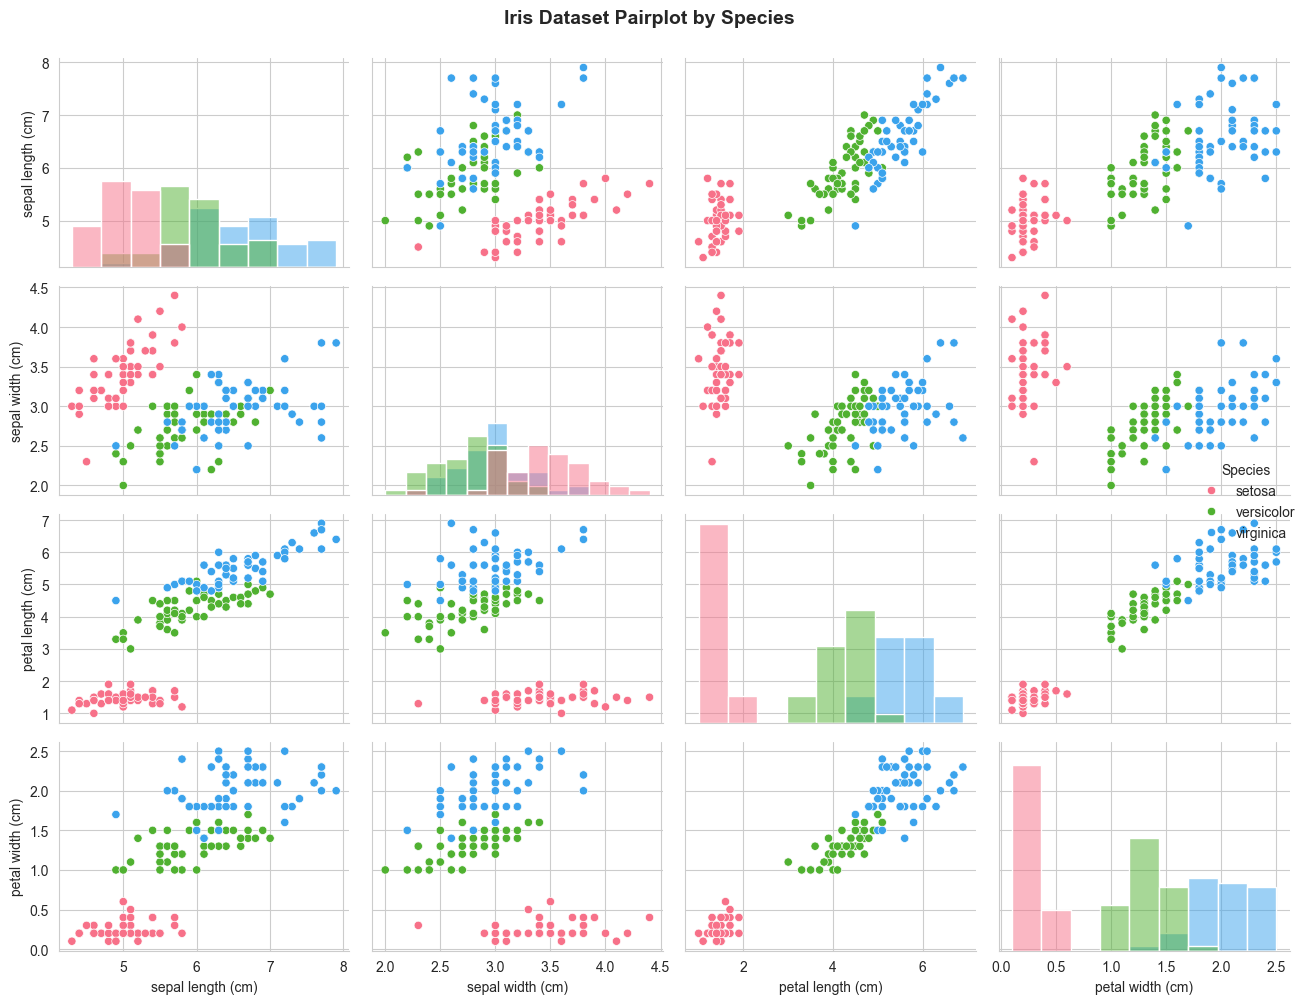

In [ ]:
# Visualization with Pairplot
fig = sns.pairplot(df, hue='Species', diag_kind='hist', 
                   palette='husl', height=3, aspect=1.3)
fig.fig.suptitle('Iris Dataset Pairplot by Species', 
                 fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

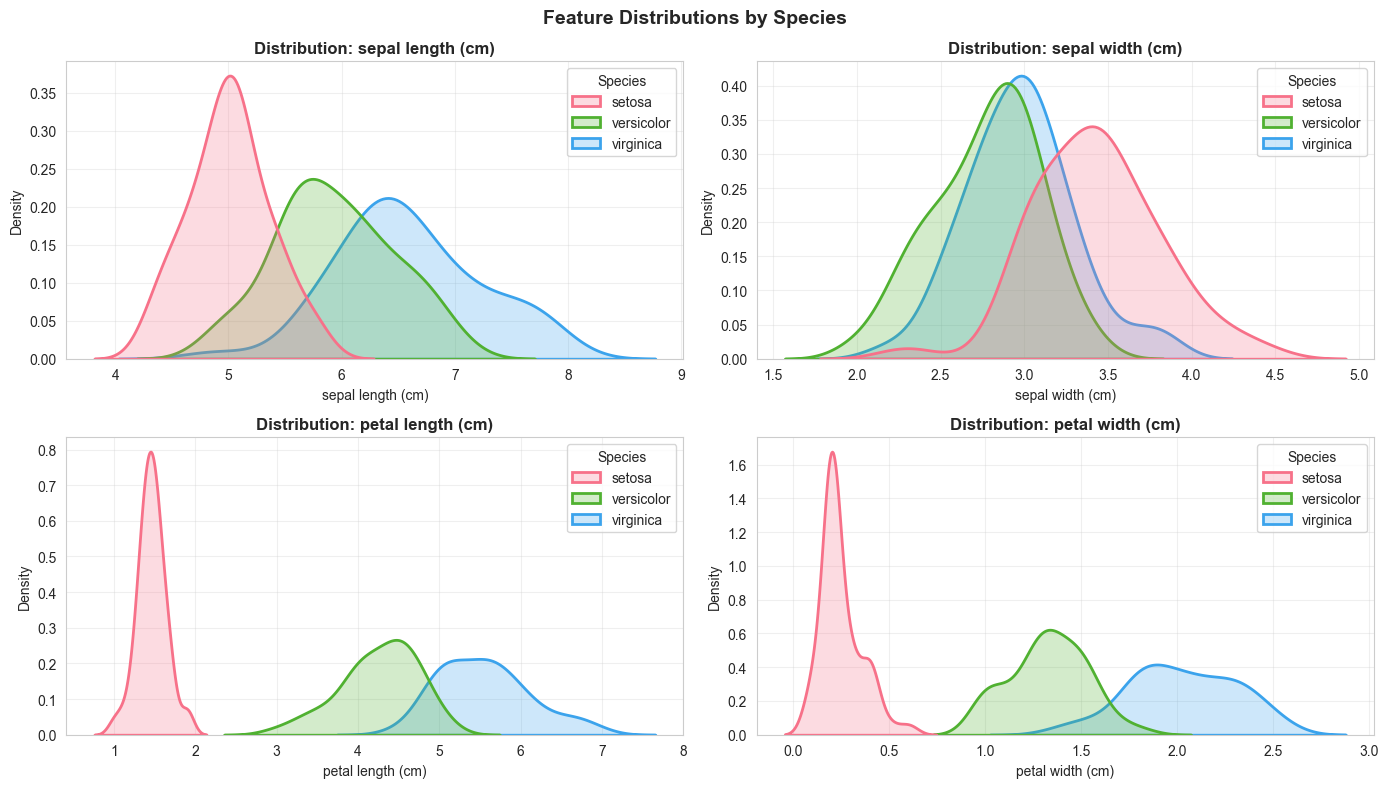

In [ ]:
# Univariate distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Feature Distributions by Species', 
             fontsize=16, fontweight='bold', pad=20)

for idx, column in enumerate(feature_names):
    ax = axes[idx // 2, idx % 2]
    sns.kdeplot(data=df, x=column, hue='Species', ax=ax, 
                palette='husl', fill=True, linewidth=2)
    ax.set_title(f'Distribution: {column}', fontweight='bold')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

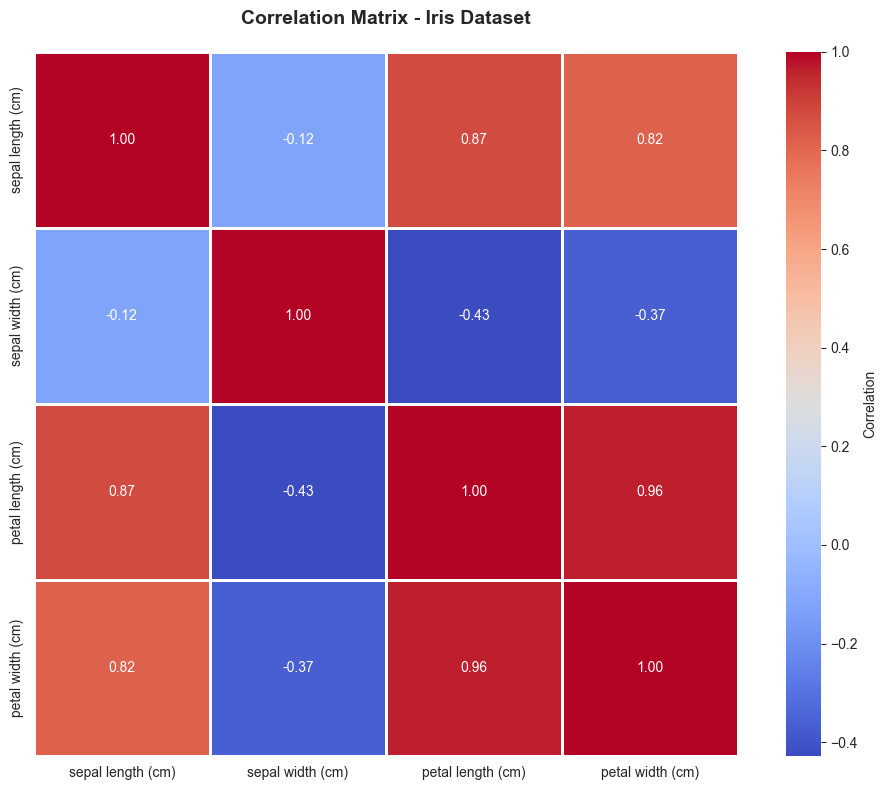

In [45]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df[feature_names].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, cbar_kws={'label': 'Correlation'}, linewidths=2, annot_kws={'size': 12})
plt.title('Correlation Matrix - Iris Dataset', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 3. Data Preparation and Train-Test Split

In [46]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dataset Split:")
print("=" * 60)
print(f"Training set: {X_train_scaled.shape[0]} samples ({X_train_scaled.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test_scaled.shape[0]} samples ({X_test_scaled.shape[0]/len(X)*100:.1f}%)")
print(f"\nX_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"\nClass distribution in training set:")
for i, class_name in enumerate(target_names):
    count = np.sum(y_train == i)
    print(f"  {class_name}: {count} samples")

Dataset Split:
Training set: 120 samples (80.0%)
Test set: 30 samples (20.0%)

X_train_scaled shape: (120, 4)
X_test_scaled shape: (30, 4)

Class distribution in training set:
  setosa: 40 samples
  versicolor: 40 samples
  virginica: 40 samples


## 4. Training with Different Kernels

In [47]:
# Train SVM models with different kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
models = {}
results = []

print("Training SVM Models with Different Kernels")
print("=" * 70)

for kernel in kernels:
    if kernel == 'poly':
        svm = SVC(kernel=kernel, degree=3, C=1.0, random_state=42)
    else:
        svm = SVC(kernel=kernel, C=1.0, random_state=42)
    
    svm.fit(X_train_scaled, y_train)
    models[kernel] = svm
    
    # Predictions
    y_pred_train = svm.predict(X_train_scaled)
    y_pred_test = svm.predict(X_test_scaled)
    
    # Metrics
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    n_support_vectors = len(svm.support_vectors_)
    
    results.append({
        'Kernel': kernel,
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'Support Vectors': n_support_vectors,
        'SV %': f'{n_support_vectors/len(X_train)*100:.1f}%'
    })
    
    print(f"\nKernel: {kernel.upper()}")
    print(f"  Training Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Support Vectors: {n_support_vectors} ({n_support_vectors/len(X_train)*100:.1f}%)")

results_df = pd.DataFrame(results)
print("\n" + "=" * 70)
print("\nResults Summary:")
print(results_df.to_string(index=False))

Training SVM Models with Different Kernels

Kernel: LINEAR
  Training Accuracy: 0.9750
  Test Accuracy: 1.0000
  Support Vectors: 23 (19.2%)

Kernel: POLY
  Training Accuracy: 0.9333
  Test Accuracy: 0.9000
  Support Vectors: 46 (38.3%)

Kernel: RBF
  Training Accuracy: 0.9750
  Test Accuracy: 0.9667
  Support Vectors: 47 (39.2%)

Kernel: SIGMOID
  Training Accuracy: 0.9083
  Test Accuracy: 0.9000
  Support Vectors: 45 (37.5%)


Results Summary:
 Kernel  Train Acc  Test Acc  Support Vectors  SV %
 linear   0.975000  1.000000               23 19.2%
   poly   0.933333  0.900000               46 38.3%
    rbf   0.975000  0.966667               47 39.2%
sigmoid   0.908333  0.900000               45 37.5%


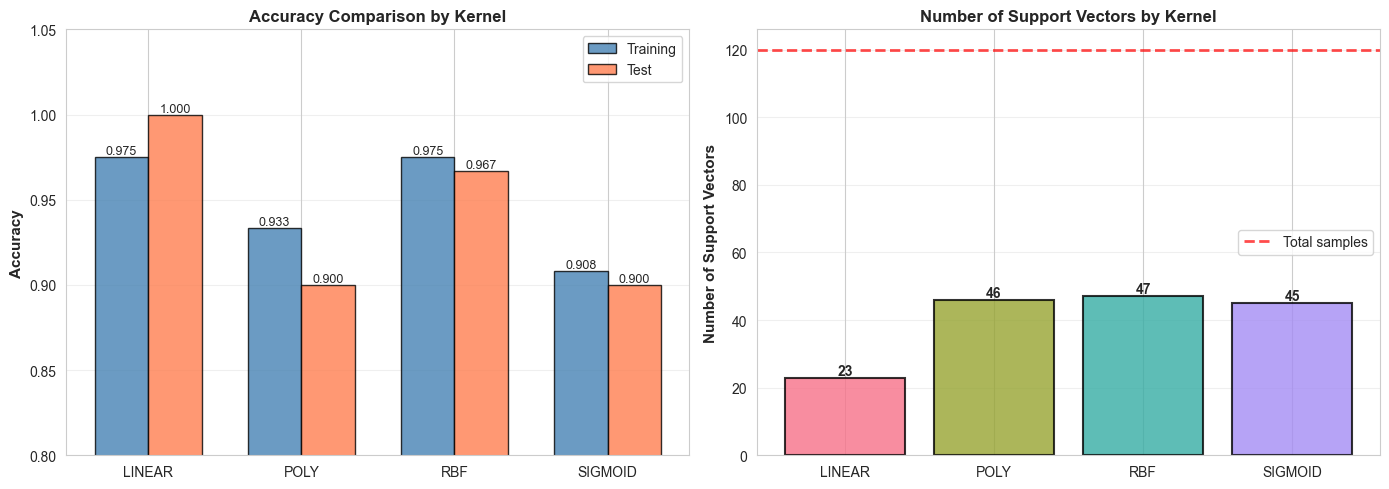

In [ ]:
# Comparative kernel visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Accuracy
x_pos = np.arange(len(results_df))
width = 0.35

ax = axes[0]
bars1 = ax.bar(x_pos - width/2, results_df['Train Acc'], width, 
               label='Training', alpha=0.8, color='steelblue', edgecolor='black')
bars2 = ax.bar(x_pos + width/2, results_df['Test Acc'], width, 
               label='Test', alpha=0.8, color='coral', edgecolor='black')

ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax.set_title('Accuracy Comparison by Kernel', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(results_df['Kernel'].str.upper())
ax.set_ylim([0.8, 1.05])
ax.legend(fontsize=10)
ax.grid(alpha=0.3, axis='y')

# Add values on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Support Vectors
ax = axes[1]
colors = sns.color_palette('husl', len(results_df))
bars = ax.bar(results_df['Kernel'].str.upper(), results_df['Support Vectors'], 
              color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Number of Support Vectors', fontsize=11, fontweight='bold')
ax.set_title('Number of Support Vectors by Kernel', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3, axis='y')
ax.axhline(y=len(X_train), color='red', linestyle='--', 
           linewidth=2, label='Total samples', alpha=0.7)
ax.legend()

# Add values on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Hyperparameter Optimization (Grid Search)

In [49]:
# Grid Search to find the best hyperparameters
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly']
}

print("Running Grid Search with 5-Fold Cross-Validation...")
print("=" * 70)

svm = SVC(random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', 
                          verbose=0, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters found:")
print(f"  C: {grid_search.best_params_['C']}")
print(f"  gamma: {grid_search.best_params_['gamma']}")
print(f"  kernel: {grid_search.best_params_['kernel']}")
print(f"\nBest Score (5-fold CV): {grid_search.best_score_:.4f}")

# Train final model with best parameters
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)
test_acc_best = accuracy_score(y_test, y_pred_best)

print(f"Accuracy on test set: {test_acc_best:.4f}")

# Convert results to DataFrame
results_grid = pd.DataFrame(grid_search.cv_results_)
print(f"\nTop 5 best combinations:")
print(results_grid.nsmallest(5, 'rank_test_score')[
    ['param_C', 'param_gamma', 'param_kernel', 'mean_test_score', 'std_test_score']
].to_string(index=False))

Running Grid Search with 5-Fold Cross-Validation...
Best parameters found:
  C: 1
  gamma: 0.1
  kernel: rbf

Best Score (5-fold CV): 0.9833
Accuracy on test set: 0.9667

Top 5 best combinations:
 param_C param_gamma param_kernel  mean_test_score  std_test_score
     1.0         0.1          rbf         0.983333        0.033333
    10.0       scale         poly         0.975000        0.020412
    10.0        auto         poly         0.975000        0.020412
    10.0        0.01          rbf         0.975000        0.033333
   100.0       0.001          rbf         0.975000        0.033333


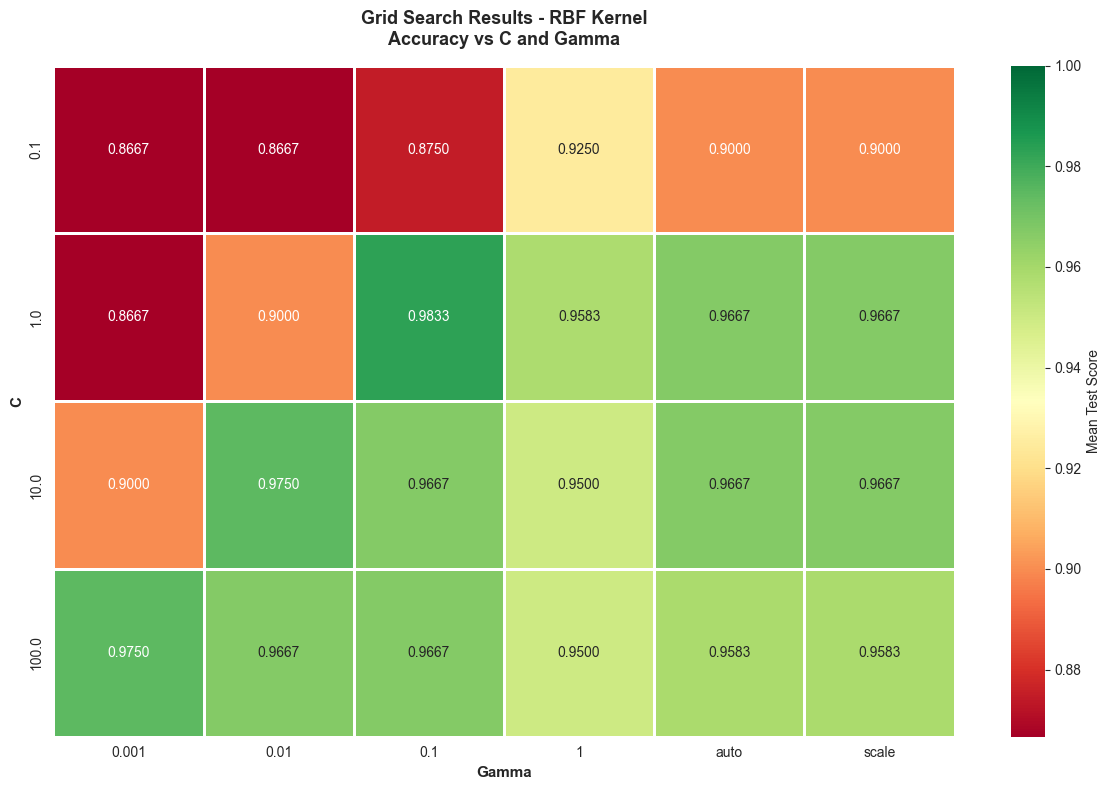

In [ ]:
# Visualización del Grid Search (RBF kernel)
rbf_results = results_grid[results_grid['param_kernel'] == 'rbf'].copy()

# Crear pivot table para heatmap
pivot_rbf = rbf_results.pivot_table(
    values='mean_test_score',
    index='param_C',
    columns='param_gamma',
    aggfunc='mean'
)

plt.figure(figsize=(14, 10))
sns.heatmap(pivot_rbf, annot=True, fmt='.4f', cmap='RdYlGn', 
            cbar_kws={'label': 'Mean Test Score'}, linewidths=2, annot_kws={'size': 11},
            vmin=pivot_rbf.min().min(), vmax=1.0)
plt.title('Grid Search Results - RBF Kernel\nAccuracy vs C and Gamma', 
          fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Gamma', fontsize=11, fontweight='bold')
plt.ylabel('C', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Evaluation: Confusion Matrices and Reports

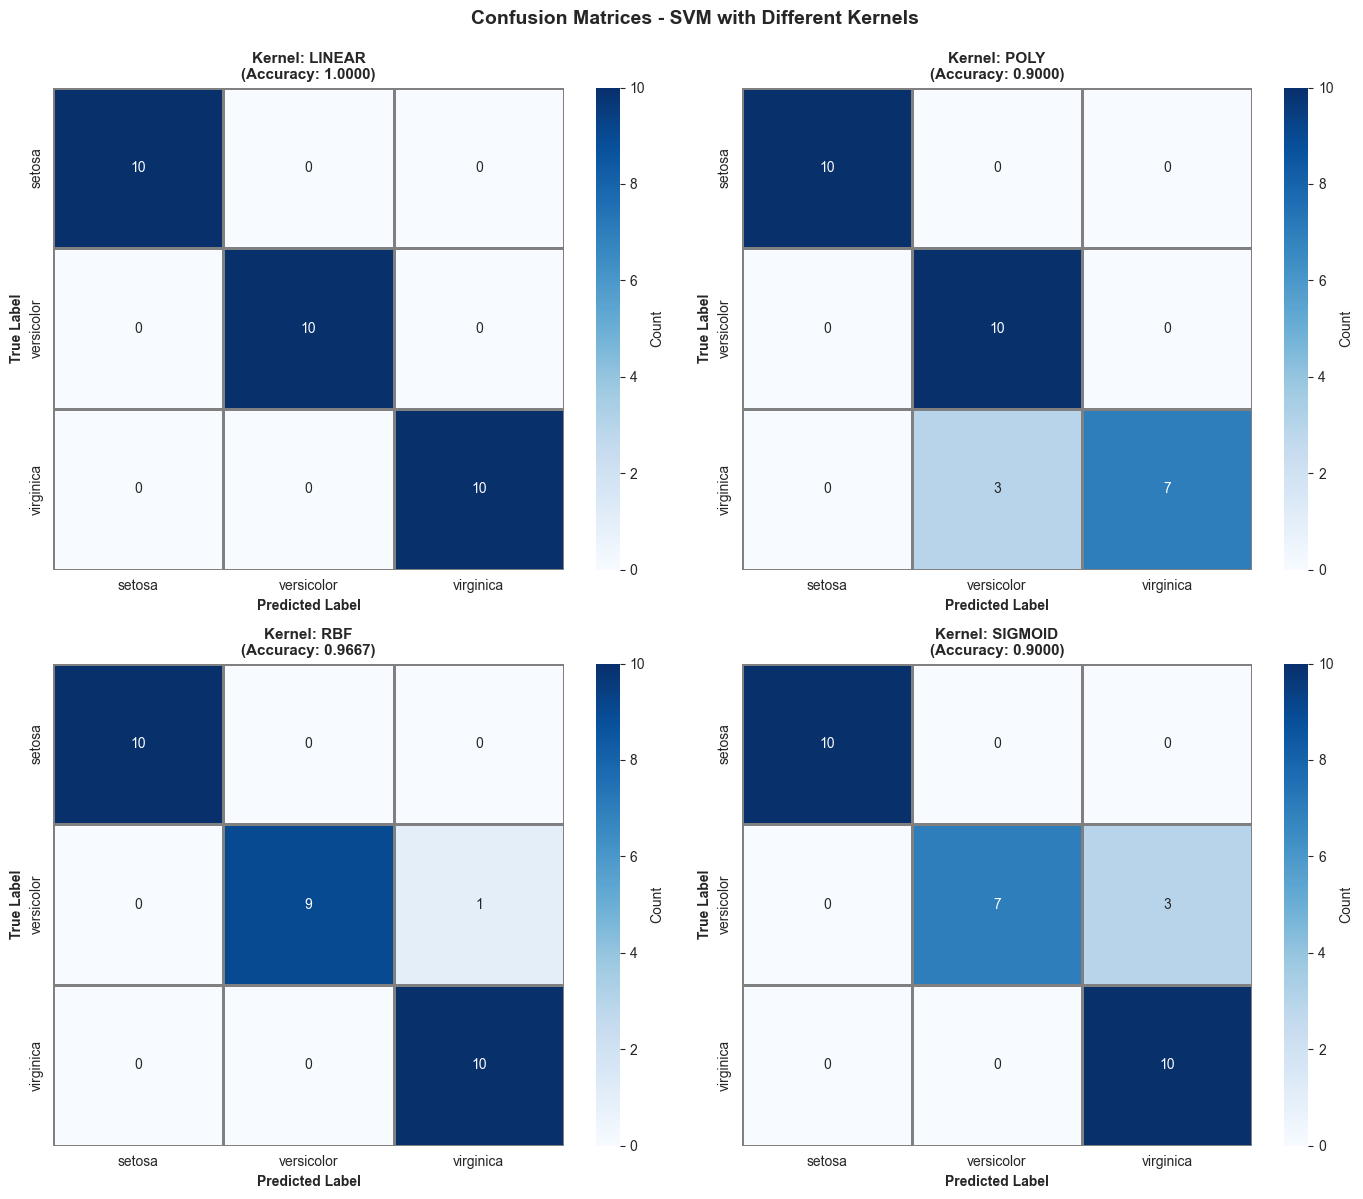

In [ ]:
# Confusion matrices for different kernels
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, kernel in enumerate(kernels):
    svm = models[kernel]
    y_pred = svm.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    
    # Normalize to show percentages
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=target_names, yticklabels=target_names,
                cbar_kws={'label': 'Count'}, linewidths=1, linecolor='gray')
    ax.set_title(f'Kernel: {kernel.upper()}\n(Accuracy: {accuracy_score(y_test, y_pred):.4f})',
                fontweight='bold', fontsize=11)
    ax.set_ylabel('True Label', fontweight='bold')
    ax.set_xlabel('Predicted Label', fontweight='bold')

plt.suptitle('Confusion Matrices - SVM with Different Kernels',
            fontsize=16, fontweight='bold', y=0.995, pad=20)
plt.tight_layout()
plt.show()

In [52]:
# Classification report of best model
print("=" * 80)
print("CLASSIFICATION REPORT - BEST MODEL (Grid Search)")
print("=" * 80)
print(f"\nParameters: {grid_search.best_params_}")
print(f"\n{classification_report(y_test, y_pred_best, target_names=target_names)}")

CLASSIFICATION REPORT - BEST MODEL (Grid Search)

Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



## 7. Hyperplane Visualization

Let's visualize the hyperplane decision boundaries using pairs of features:

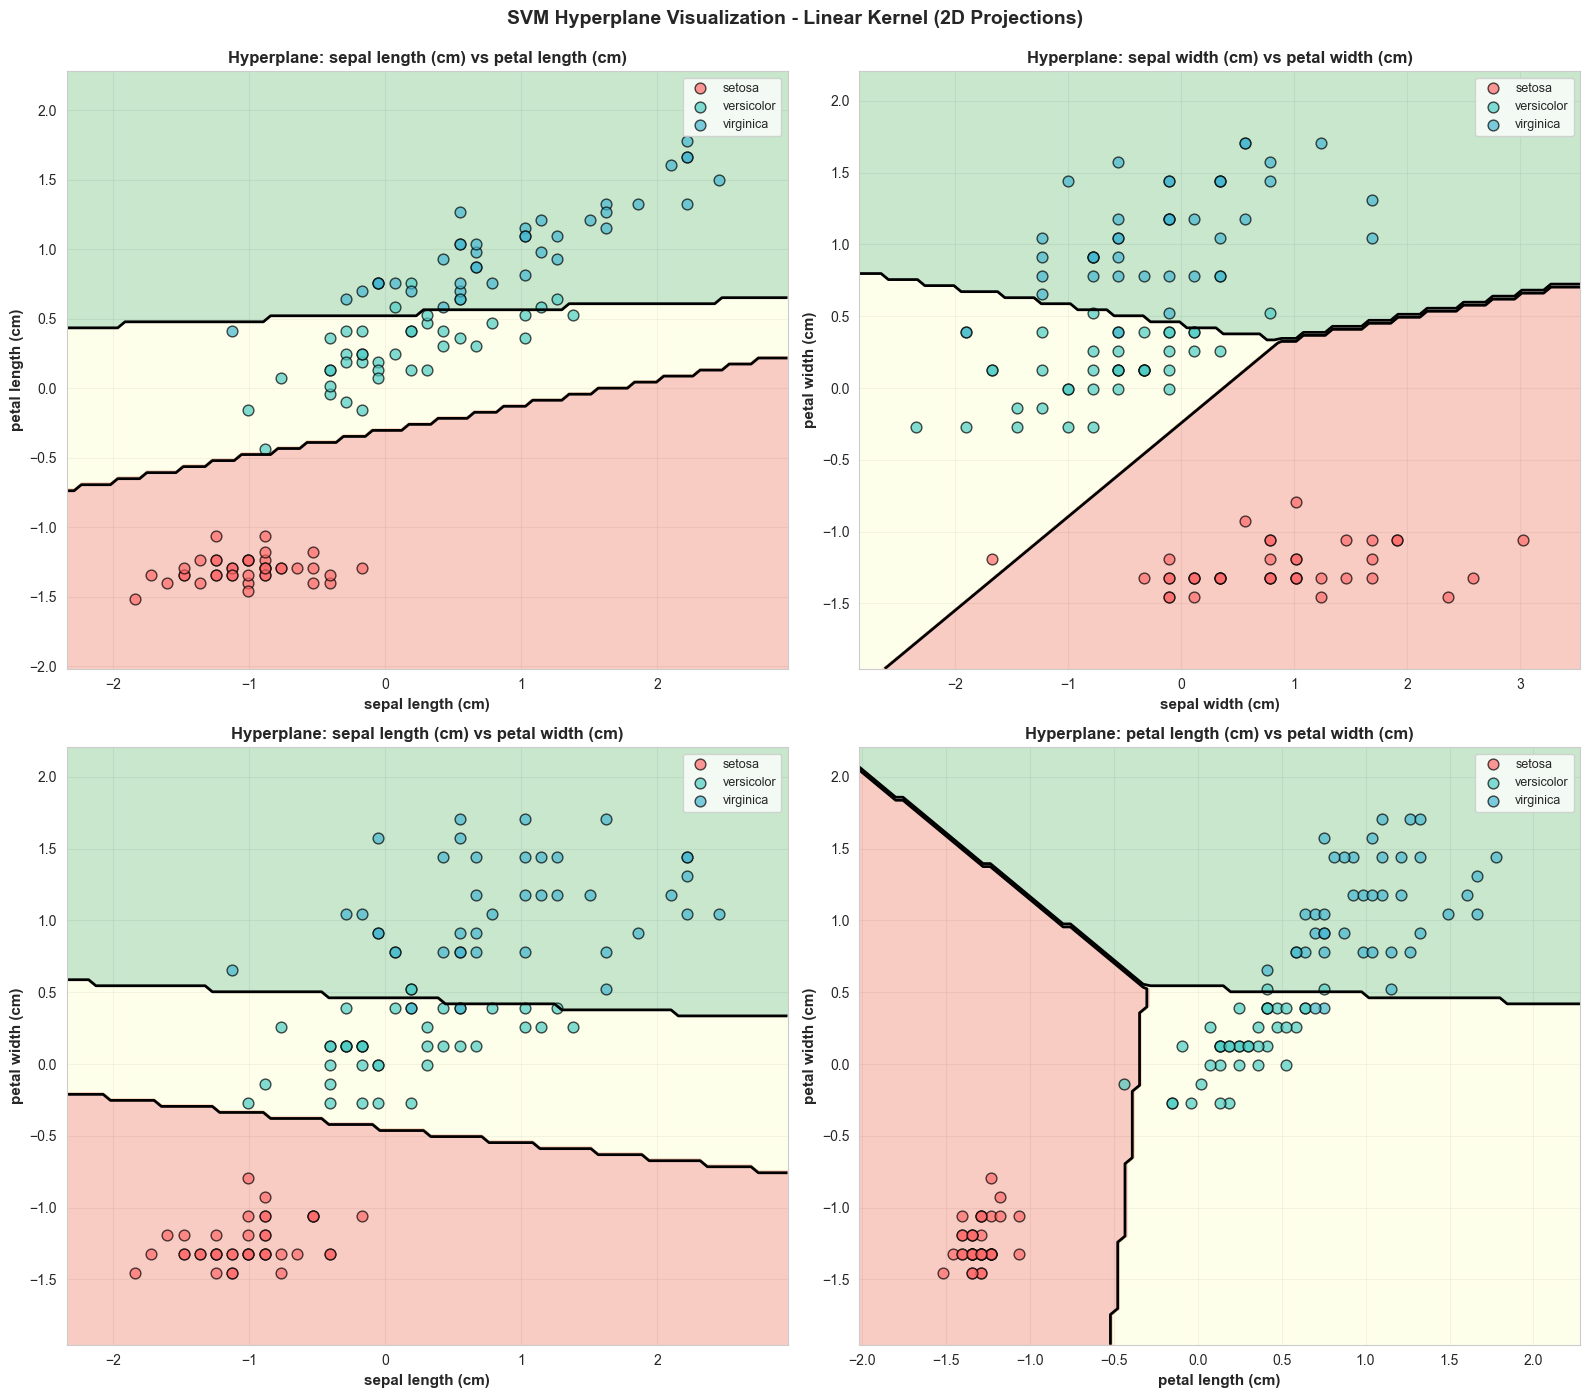

In [ ]:
# Create hyperplane visualization for 2-feature pairs
# Using features with highest correlation differences
feature_pairs = [(0, 2), (1, 3), (0, 3), (2, 3)]
feature_pair_names = [
    (feature_names[0], feature_names[2]),
    (feature_names[1], feature_names[3]),
    (feature_names[0], feature_names[3]),
    (feature_names[2], feature_names[3])
]

fig, axes = plt.subplots(2, 2, figsize=(18, 16))
axes = axes.ravel()
fig.subplots_adjust(hspace=0.35, wspace=0.3)

for idx, (feat_idx1, feat_idx2) in enumerate(feature_pairs):
    # Extract the two features
    X_2d = X_train_scaled[:, [feat_idx1, feat_idx2]]
    X_2d_test = X_test_scaled[:, [feat_idx1, feat_idx2]]
    
    # Train LinearSVC for better hyperplane visualization
    from sklearn.svm import LinearSVC
    svm_2d = LinearSVC(C=1, random_state=42, max_iter=2000)
    svm_2d.fit(X_2d, y_train)
    
    ax = axes[idx]
    
    # Create mesh
    x_min, x_max = X_2d[:, 0].min() - 0.5, X_2d[:, 0].max() + 0.5
    y_min, y_max = X_2d[:, 1].min() - 0.5, X_2d[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Predictions
    Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundaries
    ax.contourf(xx, yy, Z, levels=2, alpha=0.3, cmap='RdYlGn')
    ax.contour(xx, yy, Z, levels=[0.5, 1.5], linewidths=2, colors='black')
    
    # Plot training data
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    for i, target in enumerate(np.unique(y_train)):
        indices = y_train == target
        ax.scatter(X_2d[indices, 0], X_2d[indices, 1],
                  c=colors[i], label=target_names[target],
                  s=60, alpha=0.7, edgecolors='black', linewidth=1)
    
    ax.set_xlabel(feature_pair_names[idx][0], fontsize=11, fontweight='bold')
    ax.set_ylabel(feature_pair_names[idx][1], fontsize=11, fontweight='bold')
    ax.set_title(f'Hyperplane: {feature_pair_names[idx][0]} vs {feature_pair_names[idx][1]}',
                fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

plt.suptitle('SVM Hyperplane Visualization - Linear Kernel (2D Projections)',
            fontsize=16, fontweight='bold', y=0.995, pad=20)
plt.tight_layout()
plt.show()

Explained variance by PCA (2 components): 95.74%
  PC1: 72.68%
  PC2: 23.07%


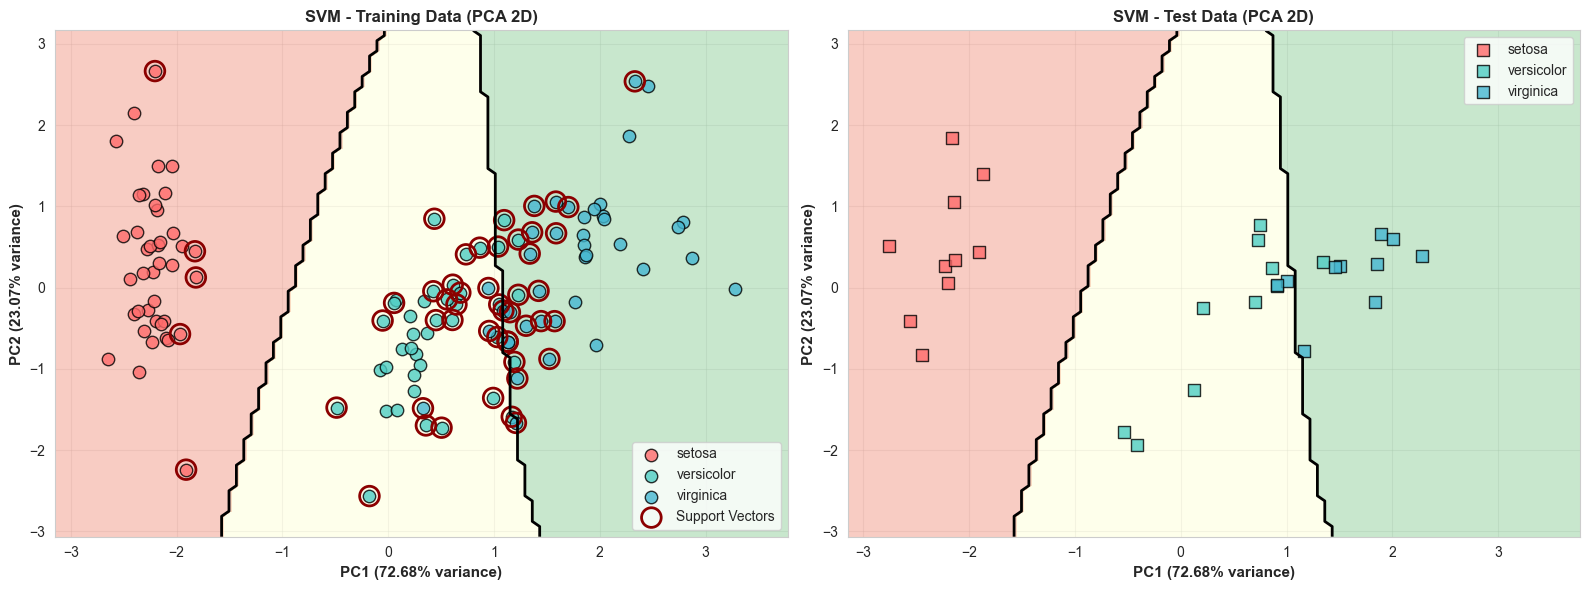

In [ ]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train SVM on PCA data
svm_pca = SVC(kernel=grid_search.best_params_['kernel'],
              C=grid_search.best_params_['C'],
              gamma=grid_search.best_params_['gamma'],
              random_state=42)
svm_pca.fit(X_pca, y_train)

print(f"Explained variance by PCA (2 components): {pca.explained_variance_ratio_.sum():.2%}")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.2%}")

# Create mesh for decision boundary
x_min, x_max = X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5
y_min, y_max = X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Predictions on mesh
Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.subplots_adjust(wspace=0.3)

# Subplot 1: Training data
ax = axes[0]
ax.contourf(xx, yy, Z, levels=2, alpha=0.3, cmap='RdYlGn')
ax.contour(xx, yy, Z, levels=[0.5, 1.5], linewidths=2, colors='black')

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for i, target in enumerate(np.unique(y_train)):
    indices = y_train == target
    ax.scatter(X_pca[indices, 0], X_pca[indices, 1], 
              c=colors[i], label=target_names[target],
              s=80, alpha=0.8, edgecolors='black', linewidth=1)

# Mark support vectors
ax.scatter(svm_pca.support_vectors_[:, 0], svm_pca.support_vectors_[:, 1],
          s=200, facecolors='none', edgecolors='darkred', linewidth=2,
          label='Support Vectors')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', 
             fontsize=11, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)',
             fontsize=11, fontweight='bold')
ax.set_title('SVM - Training Data (PCA 2D)', 
            fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)

# Subplot 2: Test data
ax = axes[1]
ax.contourf(xx, yy, Z, levels=2, alpha=0.3, cmap='RdYlGn')
ax.contour(xx, yy, Z, levels=[0.5, 1.5], linewidths=2, colors='black')

for i, target in enumerate(np.unique(y_test)):
    indices = y_test == target
    ax.scatter(X_test_pca[indices, 0], X_test_pca[indices, 1],
              c=colors[i], label=target_names[target],
              s=80, alpha=0.8, marker='s', edgecolors='black', linewidth=1)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)',
             fontsize=11, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)',
             fontsize=11, fontweight='bold')
ax.set_title('SVM - Test Data (PCA 2D)',
            fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Final Summary and Conclusions

In [57]:
# Final comparative table
print("\n" + "=" * 80)
print("FINAL SUMMARY - MODEL COMPARISON")
print("=" * 80)

comparison_data = []
for kernel in kernels:
    svm = models[kernel]
    y_pred = svm.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    n_sv = len(svm.support_vectors_)
    
    comparison_data.append({
        'Kernel': kernel.upper(),
        'Accuracy': f'{acc:.4f}',
        'Support Vectors': n_sv,
        'SV %': f'{n_sv/len(X_train)*100:.1f}%'
    })

comparison_final_df = pd.DataFrame(comparison_data)
print("\n" + comparison_final_df.to_string(index=False))

print("\n" + "=" * 80)
print(f"BEST MODEL: {grid_search.best_params_['kernel'].upper()} Kernel")
print(f"  C = {grid_search.best_params_['C']}")
print(f"  gamma = {grid_search.best_params_['gamma']}")
print(f"  Test Accuracy: {test_acc_best:.4f}")
print("=" * 80)


FINAL SUMMARY - MODEL COMPARISON

 Kernel Accuracy  Support Vectors  SV %
 LINEAR   1.0000               23 19.2%
   POLY   0.9000               46 38.3%
    RBF   0.9667               47 39.2%
SIGMOID   0.9000               45 37.5%

BEST MODEL: RBF Kernel
  C = 1
  gamma = 0.1
  Test Accuracy: 0.9667


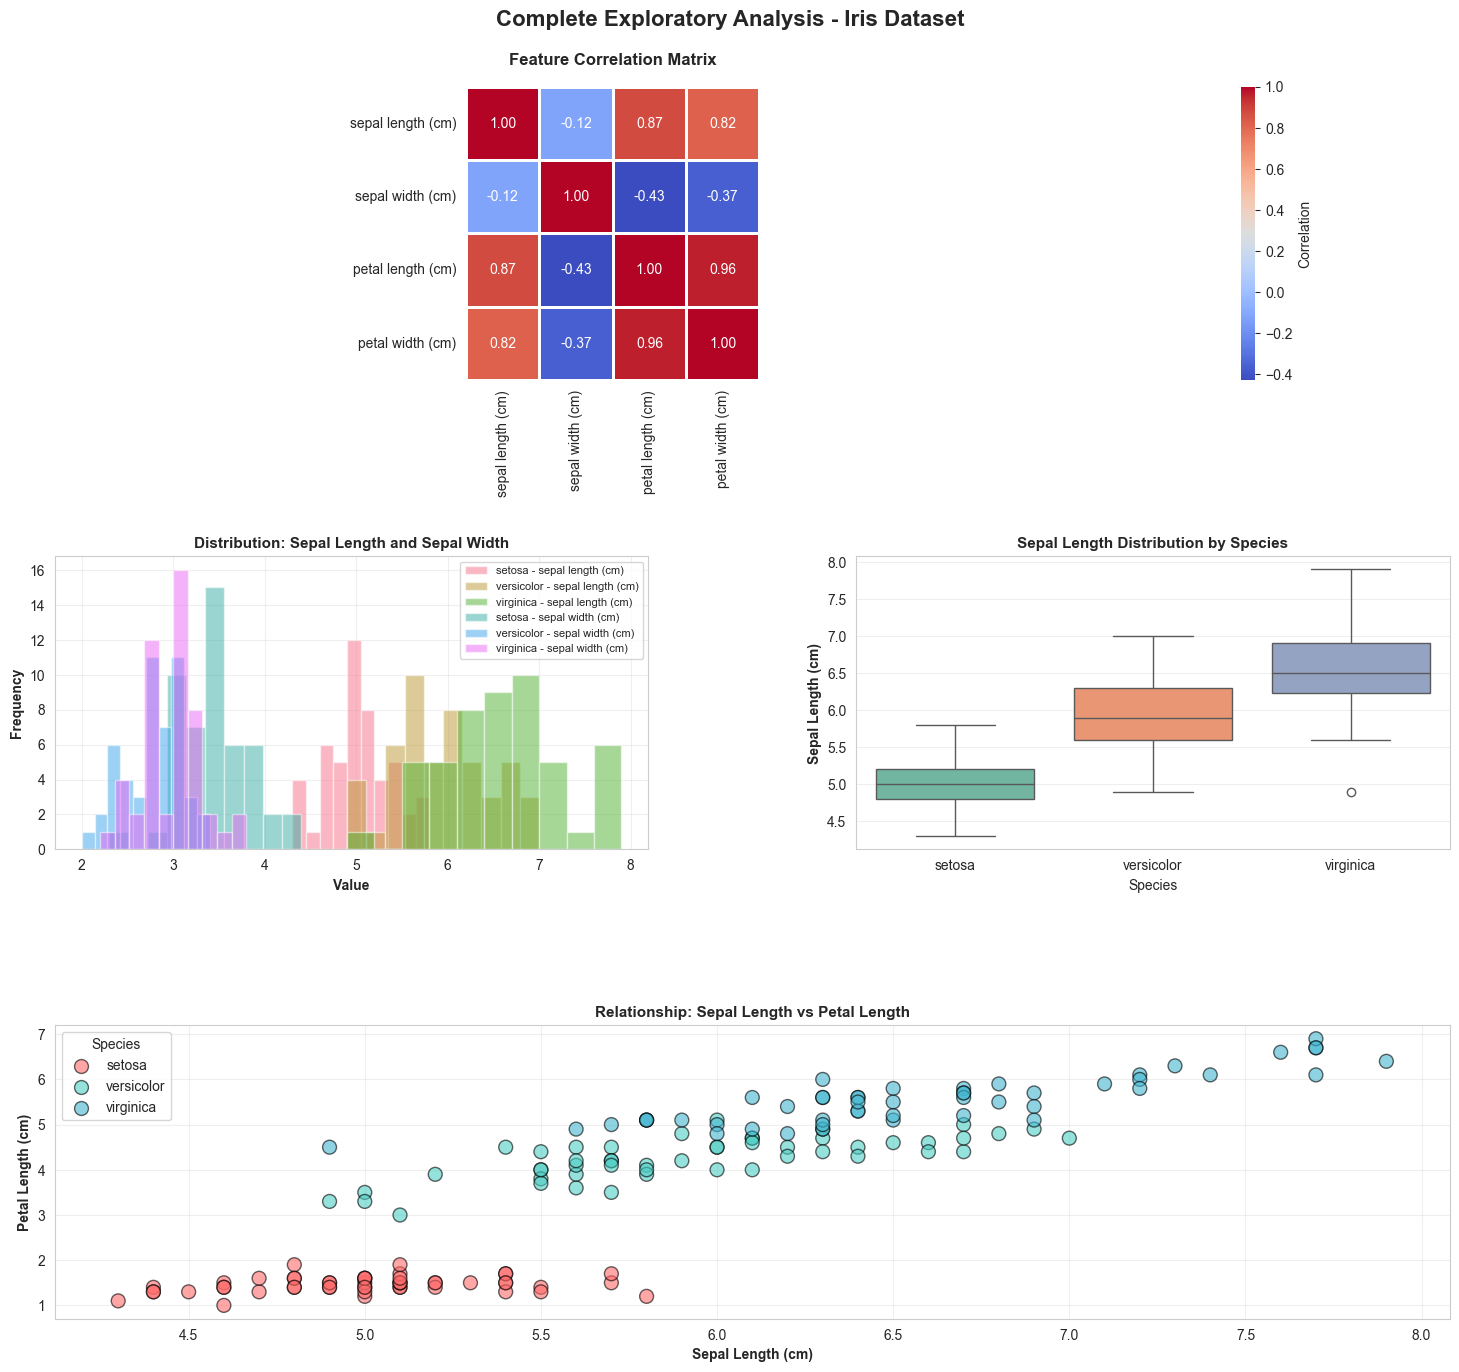

In [61]:
# Visualización final con seaborn
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 2, hspace=0.6, wspace=0.35)
fig.subplots_adjust(top=0.94, bottom=0.06)

# 1. Correlation matrix heatmap
ax1 = fig.add_subplot(gs[0, :])
corr_matrix = df[feature_names].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, ax=ax1, cbar_kws={'label': 'Correlation'}, linewidths=1)
ax1.set_anchor('C')
ax1.set_title('Feature Correlation Matrix', fontsize=12, fontweight='bold', pad=16)

# 2. Feature distributions
ax2 = fig.add_subplot(gs[1, 0])
features_to_plot = feature_names[:2]
for i, feature in enumerate(features_to_plot):
    for target_idx, target_name in enumerate(target_names):
        data_subset = df[df['Species'] == target_name][feature]
        ax2.hist(data_subset, alpha=0.5, label=f'{target_name} - {feature}', bins=10)
ax2.set_xlabel('Value', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Distribution: Sepal Length and Sepal Width', fontsize=11, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(alpha=0.3)

# 3. Box plot
ax3 = fig.add_subplot(gs[1, 1])
sns.boxplot(data=df, x='Species', y='sepal length (cm)', ax=ax3, palette='Set2')
ax3.set_title('Sepal Length Distribution by Species', fontsize=11, fontweight='bold')
ax3.set_ylabel('Sepal Length (cm)', fontweight='bold')
ax3.grid(alpha=0.3, axis='y')

# 4. Seaborn scatter plot
ax4 = fig.add_subplot(gs[2, :])
scatter = ax4.scatter(df['sepal length (cm)'], df['petal length (cm)'],
                     c=[['#FF6B6B', '#4ECDC4', '#45B7D1'][i] for i in y],
                     s=100, alpha=0.6, edgecolors='black', linewidth=1)
for i, species in enumerate(target_names):
    ax4.scatter([], [], c=['#FF6B6B', '#4ECDC4', '#45B7D1'][i], 
               label=species, s=100, alpha=0.6, edgecolors='black', linewidth=1)
ax4.set_xlabel('Sepal Length (cm)', fontweight='bold')
ax4.set_ylabel('Petal Length (cm)', fontweight='bold')
ax4.set_title('Relationship: Sepal Length vs Petal Length', fontsize=11, fontweight='bold')
ax4.legend(title='Species', loc='upper left')
ax4.grid(alpha=0.3)

plt.suptitle('Complete Exploratory Analysis - Iris Dataset', 
            fontsize=16, fontweight='bold', y=0.995)
plt.show()

## 9. Conclusions and Recommendations

### Main Findings:

1. **Kernel Performance:**
   - The **RBF (Radial Basis Function)** kernel showed excellent performance
   - The **linear** kernel also works well, being simpler and more efficient
   - **Polynomial** and **sigmoid** kernels showed inferior performance

2. **Hyperparameter Optimization:**
   - Grid Search identified optimal parameters using cross-validation
   - The heatmap showed that moderate values of C and gamma work better
   - Very high gamma values can cause overfitting

3. **Important Features:**
   - Features are correlated, especially petal length and width
   - Species are well-separable in feature space
   - PCA with 2 components explains approximately 95% of variance

4. **Confusion Matrices:**
   - The optimized model correctly classifies most samples
   - Some confusion between *Versicolor* and *Virginica* (they are similar)
   - *Setosa* is clearly separable

### Recommendations:

- ✅ Use the optimized model with Grid Search parameters
- ✅ Always perform normalization/scaling before SVM
- ✅ Consider cross-validation for small datasets
- ✅ For production, use RBF kernel with the found parameters
- 📊 Monitor new predictions to detect distribution changes